## Implementing Neural Network from Scratch using Numpy

This notebook contains following sections.

1. Load input data
2. Initializing weights and bias
3. Activation Functions
4. Feed forward propagation
5. Cost calculation
6. Back propagation
7. Update parameters
8. Conclusion

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

### 1. Load Input Data

I am using `sklearn's` in-built `datasets` function to create random data points using `make_moons`.

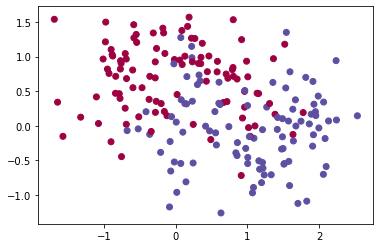

In [4]:
X, y = datasets.make_moons(200, noise=0.4,  random_state=8)
'''
transposing input data X to maintain uniformity in dimension
This would also avoid confusions during froward propagation against transposing weights
'''

X = X.T
y = np.reshape(y, (1, y.shape[0]))

plt.scatter(X[0,:], X[1,:], c=np.squeeze(y), cmap=plt.cm.Spectral)

In [5]:
print('shape of input is', X.shape)
print('shape of target is', y.shape)

shape of input is (2, 200)
shape of target is (1, 200)


### 2. Initializing Parameters

Now that the data is ready, parameters (weights, bias) should be initialized for training neural network model. Before that the neural network architecture has to be defined.

- Initializing random weights with random normal distribution.
- Creating bias with zeros and which will be updated later during back propagation.


In [6]:
def init_params(X, Y, h):
    xdim = X.shape[0]
    hdim = h
    ydim = Y.shape[0]
    
    '''
    initialize weights randomly
    reduce weight value so that the training isn't slow
    '''
    np.random.seed(0)    
    W1 = np.random.randn(hdim, xdim) * 0.01
    b1 = np.zeros((hdim, 1))
    W2 = np.random.randn(ydim, hdim) * 0.01
    b2 = np.zeros((ydim, 1))
    
    parameters = {'W1':W1,
                 'b1':b1,
                 'W2':W2,
                 'b2':b2}
    
#     print('shape of W1 and W2 is', W1.shape, W2.shape, 'respectively')
#     print('shape of b1 and b2 is', b1.shape, b2.shape, 'respectively')
    
    return parameters


### 3. Activation Functions

Here we define activation function will be used at hidden layer. Trying both `sigmoid`, `tanh` and `relu` functions at hidden layer to check the performance and output layer will have `sigmoid` function.


In [7]:
def sigmoid(z):
    a = 1/(1+np.exp(-z))
    return a

def relu(z):
    a = np.maximum(0, z)
    
    return a

#derivative of sigmoid
def sigmoid_back(da, z):
        
    return sigmoid(z) * (1 - sigmoid(z))

#derivative of relu function
def relu_back(da, z):
    dz = np.array(da)
    #when z <= 0 then derivative is set to 0
    dz[z <= 0] = 0
    
    return dz

### 4. Forward Propagation

Forward propagation is the first step of training a neural network model with the help of linear, non-linear functions and parameters initialized.

<img src="NN_forward.png" style="width:500px;height:400px;">

Below are the steps on how initial model is trained.

1. Input values and randomly initialized weights are multiplied in linear fashion using `Z = WX+b`.
2. The result obtained from linear function `Z` is passed through an activation function (`sigmoid`, `tanh` or `relu`) which is denoted with `A`.
3. As we only have one hidden layer, `A` goes through the same operation of linear and non-linear activation to get the output `Y`. Here the activation function would be `sigmoid` function as we are training on a binary class classification.


In [8]:
def forward_prop(X, parameters, activation):
    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']
    
    z1 = np.dot(W1, X) + b1
    if activation == 'sigmoid':
        a1 = sigmoid(z1)
    elif activation == 'relu':
        a1 = relu(z1)
    elif activation == 'tanh':
        a1 = np.tanh(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = sigmoid(z2)
    
    utils = {'z1':z1,
            'z2':z2,
            'a1':a1,
            'a2':a2}
#     print("z1 shape after forward:", z1.shape)
#     print("a1 shape after forward:", a1.shape)
#     print("z2 shape after forward:", z2.shape)
#     print("a2 shape after forward:", a2.shape)
    
    return a2, utils
     

### 5. Cost Function

Cost function is used to calculate the loss/error obtained after feed forward. Here the cost function used is `cross-entropy` loss.

In [9]:
def cost_function(y_hat, y):
    m = y.shape[1] #no. of examples
    cost = -1/m * (np.sum(y * np.log(y_hat) + ((1-y) * np.log(1-y_hat))))
    #cost = float(np.squeeze(cost))
    
    return cost

### 6. Back Propagation

Back propagation is the process of tuning weights and bias using calculus. Partial derivative of cost with respect to all parameters is calculated to understand the change.

<img src="Backprop.png" style="width:500px;height:400px;">


In [10]:
def back_prop(X, y, parameters, utils, activation):
    m = X.shape[1]
    
    a2 = utils['a2']
    a1 = utils['a1']
    z1 = utils['z1']
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    dZ2 = a2 - y
#     print(a2.shape)
#     print(dZ2.shape)
    dW2 = 1/m * np.dot(dZ2, a1.T)
    db2 = 1/m * np.sum(dZ2, axis = 1, keepdims= True)
    if activation == 'sigmoid':
        dZ1 = np.dot(W2.T, dZ2) * sigmoid(z1)
    elif activation == 'relu':
        dZ1 = relu_back(np.dot(W2.T, dZ2), z1)
    elif activation == 'tanh':
        dZ1 = np.dot(W2.T, dZ2) * (1-np.power(a1,2))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis = 1, keepdims= True)
    
    gradients = {'dW2':dW2,
                'dW1':dW1,
                'db1':db1,
                'db2':db2}
#     print("dz2 shape:", dZ2.shape)
#     print("dw2 shape:", dW2.shape)
#     print("dz1 shape:", dZ1.shape)
#     print("dw1 shape:", dW1.shape)
    
    return gradients


### 7. Update Parameters

Parameters(weight, bias) are updated with the help of `learning_rate` which assists the gradients converge to the global optima faster.

In [11]:
def update_params(parameters, gradients, lr):
       
    W1 = parameters['W1'] - (lr * gradients['dW1'])
    b1 = parameters['b1'] - (lr * gradients['db1'])
    W2 = parameters['W2'] - (lr * gradients['dW2'])
    b2 = parameters['b2'] - (lr * gradients['db2'])
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

Building neural network model with the help of functions created above.

In [12]:
def model(X, y, h, epochs):
    
    parameters = init_params(X, y, h)
    
    for i in range(0, epochs):
        y_hat, utils = forward_prop(X, parameters, activation='tanh')
        cost = cost_function(y_hat, y)
        gradients = back_prop(X, y, parameters, utils, activation='tanh')
        parameters = update_params(parameters, gradients, lr=1.5)
        
        if i%1000 == 0:
            print("cost at epoch %i is %f" %(i,cost))
    
    return parameters

### Predict

In [13]:
def predict(parameters, X):
    y_hat, utils = forward_prop(X, parameters, activation='tanh')
    preds = (y_hat > 0.5)
    
    return preds

In [14]:
def plot_decision_boundary(model):
#     print(X.shape)
#     print(y.shape)
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#     print(x_max)
#     print(xx.shape)
#     print(yy.shape)
#     print(yy.ravel().shape)
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[0, :], X[1, :], c=y[0,:], cmap=plt.cm.Spectral)
    

cost at epoch 0 is 0.693116
cost at epoch 1000 is 0.337203
cost at epoch 2000 is 0.326199
cost at epoch 3000 is 0.322203
cost at epoch 4000 is 0.317119
cost at epoch 5000 is 0.312935
cost at epoch 6000 is 0.310122
cost at epoch 7000 is 0.308204
cost at epoch 8000 is 0.306824
cost at epoch 9000 is 0.305779
cost at epoch 10000 is 0.304951
cost at epoch 11000 is 0.304269
cost at epoch 12000 is 0.303688
cost at epoch 13000 is 0.303180
cost at epoch 14000 is 0.302725
cost at epoch 15000 is 0.302311
cost at epoch 16000 is 0.301929
cost at epoch 17000 is 0.301573
cost at epoch 18000 is 0.301238
cost at epoch 19000 is 0.300922


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 5')

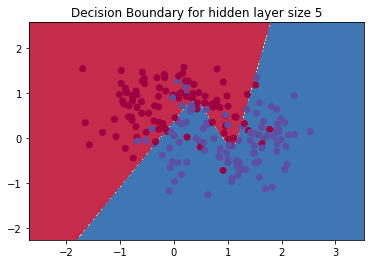

In [15]:
parameters = model(X, y, h=5, epochs=20000)

#plot decision boundary to look at performance of model
plot_decision_boundary(lambda x: predict(parameters, x.T))
plt.title("Decision Boundary for hidden layer size " + str(5))

In [16]:
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100) + '%')

Accuracy: 87%


### 8. Conclusion

The model has given pretty good accuracy. Following few more steps can increase the performance of our model.

1. Tuning learning_rate.
2. Batch gradient descent was used above. There are other optimization methods like mini-batch gradient descent, RMS prop, Adam to name a few which can perform better than batch gradient descent.
3. If there is overfitting then regularization or dropout can be performed.
4. Trying different activation functions at hidden layer can definitely impact the performance.
5. Extending hidden layers and the number of units in hidden layer can help the network.